# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [57]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [58]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train_first, y_train_first), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_first, y_train_first, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

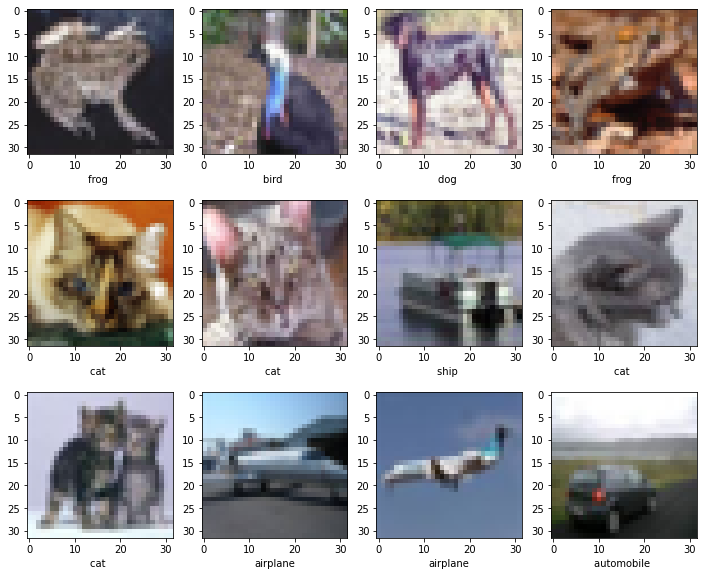

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])


Добавим аугментацию:

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [61]:
X_datagen = ImageDataGenerator(featurewise_center=True, 
                               featurewise_std_normalization=True, 
                               rotation_range=20, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               horizontal_flip=True)

In [62]:
X_datagen.fit(X_train)

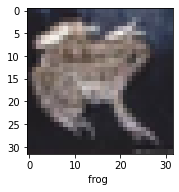

In [63]:
plt.figure(figsize=[12,10])
plt.subplot(3, 4, 1)
plt.xlabel(class_names[y_train[0, 0]])
plt.imshow(X_train[0])

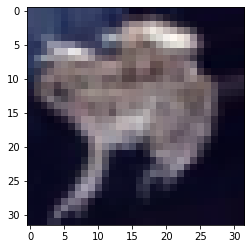

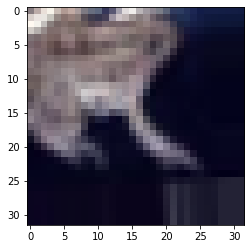

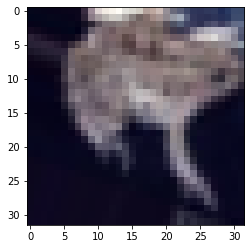

In [64]:
from tensorflow.keras.preprocessing import image

x = image.img_to_array(X_train[0])
x = X_train[0].reshape((1,) + X_train[0].shape) # изменение формы на (1, 32, 32, 3)
i = 0
for batch in X_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 3:
        break
plt.show()

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [65]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [12]:
import keras
from keras import layers as L
from keras import backend as K

In [ ]:
hid_size = 256
m = keras.metrics.Accuracy(name='accuracy')

model = keras.Sequential(
    [
     L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])),
     L.Flatten(),
    #  L.Dense(64, activation='relu'),
     L.Dense(35, activation='relu'),
    L.Dense(10, activation='softmax'),
    ]
        
    )
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=m)                                                         # Your code here
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
flatten_19 (Flatten)         (None, 262144)            0         
_________________________________________________________________
dense_58 (Dense)             (None, 35)                9175075   
_________________________________________________________________
dense_59 (Dense)             (None, 10)                360       
Total params: 9,176,459
Trainable params: 9,176,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dummy_pred = model.predict_proba(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэнтропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
# y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [13]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=2),
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='sgd', 
    metrics='sparse_categorical_accuracy')

In [ ]:
model.fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/500
80/80 - 6s - loss: 2.1547 - sparse_categorical_accuracy: 0.2312 - val_loss: 2.0612 - val_sparse_categorical_accuracy: 0.2758
Epoch 2/500
80/80 - 5s - loss: 2.0011 - sparse_categorical_accuracy: 0.3068 - val_loss: 1.9509 - val_sparse_categorical_accuracy: 0.3270
Epoch 3/500
80/80 - 5s - loss: 1.9251 - sparse_categorical_accuracy: 0.3316 - val_loss: 1.9020 - val_sparse_categorical_accuracy: 0.3380
Epoch 4/500
80/80 - 5s - loss: 1.8835 - sparse_categorical_accuracy: 0.3455 - val_loss: 1.8618 - val_sparse_categorical_accuracy: 0.3477
Epoch 5/500
80/80 - 5s - loss: 1.8492 - sparse_categorical_accuracy: 0.3570 - val_loss: 1.8693 - val_sparse_categorical_accuracy: 0.3416
Epoch 6/500
80/80 - 5s - loss: 1.8292 - sparse_categorical_accuracy: 0.3632 - val_loss: 1.8358 - val_sparse_categorical_accuracy: 0.3598
Epoch 7/500
80/80 - 5s - loss: 1.8129 - sparse_categorical_accuracy: 0.3706 - val_loss: 1.7971 - val_sparse_categorical_accuracy: 0.3691
Epoch 8/500
80/80 - 5s - loss: 1.7910 - s

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



 Test_acc = 0.4526
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:]))),
model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())
model.add(L.Dense(units=100, activation='relu'))
model.add(L.Dense(units=10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 10)        23050     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               256100    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 281,184
Trainable params: 281,184
Non-trainable params: 0
________________________________________________

In [ ]:
model.fit(X_train, y_train, batch_size=2000, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/500
20/20 - 46s - loss: 2.3506 - acc: 0.1077 - val_loss: 2.2819 - val_acc: 0.1139
Epoch 2/500
20/20 - 12s - loss: 2.2477 - acc: 0.1647 - val_loss: 2.1903 - val_acc: 0.2071
Epoch 3/500
20/20 - 12s - loss: 2.1080 - acc: 0.2393 - val_loss: 2.0105 - val_acc: 0.2813
Epoch 4/500
20/20 - 12s - loss: 1.9441 - acc: 0.3083 - val_loss: 1.8948 - val_acc: 0.3187
Epoch 5/500
20/20 - 12s - loss: 1.8575 - acc: 0.3455 - val_loss: 1.8309 - val_acc: 0.3526
Epoch 6/500
20/20 - 12s - loss: 1.8062 - acc: 0.3685 - val_loss: 1.7838 - val_acc: 0.3695
Epoch 7/500
20/20 - 12s - loss: 1.7616 - acc: 0.3849 - val_loss: 1.7464 - val_acc: 0.3857
Epoch 8/500
20/20 - 12s - loss: 1.7291 - acc: 0.3939 - val_loss: 1.7308 - val_acc: 0.3907
Epoch 9/500
20/20 - 12s - loss: 1.6986 - acc: 0.4025 - val_loss: 1.6964 - val_acc: 0.3998
Epoch 10/500
20/20 - 12s - loss: 1.6710 - acc: 0.4123 - val_loss: 1.6684 - val_acc: 0.4067
Epoch 11/500
20/20 - 12s - loss: 1.6457 - acc: 0.4212 - val_loss: 1.6465 - val_acc: 0.4153
Epoch 12

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



 Test_acc = 0.5582
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.sparse_categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict_classes(X_test))))

In [ ]:
!rm -rf ./logs

In [ ]:
from keras import optimizers as o

In [ ]:
optimizers = {
    # 'optimizer_name': optimizer
    'SGD': o.SGD(),
    'RMSprop': o.RMSprop(), 
    'Adam': o.Adam(), 
    'Adamax': o.Adamax(),
    'Adadelta': o.Adadelta(),
    'Adagrad': o.Adagrad(),
    'Adamax': o.Adamax(),
    'Nadam': o.Nadam(),
    'Ftrl': o.Ftrl()

}

In [ ]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Final score of single_model_SGD is 0.1
Final score of single_model_RMSprop is 0.5476
Final score of single_model_Adam is 0.5362
Final score of single_model_Adamax is 0.5716
Final score of single_model_Adadelta is 0.3499
Final score of single_model_Adagrad is 0.4636
Final score of single_model_Nadam is 0.5298
Final score of single_model_Ftrl is 0.1


Прокомментируйте полученные результаты.

*Таким образом, мы видим, что оптимизация Adamax показала наилучший результат. Получается, расчёт инерционного момента распределения градиентов произвольной степени p при p, стремящемся к бесконечности, в данном случае, на этом наборе признаков использовать эффективнее.  
Наименьший же accuracy получился при использовании оптимизаторов SGD и Ftrl. При этом хотелось бы отметить, что в самый первый запуск модели я уже попробовала использовать SGD, но ввиду низкого результата, не стала оставлять подобный вариант.*

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [ ]:
hid_size=256
from sklearn.metrics import accuracy_score

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization())

model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization())

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))
model.add(L.BatchNormalization())

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 10)        23050     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 10)        40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

In [ ]:
model.fit(X_train, y_train, batch_size=100, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/500
400/400 - 21s - loss: 1.4708 - acc: 0.4791 - val_loss: 2.0590 - val_acc: 0.2641
Epoch 2/500
400/400 - 20s - loss: 1.1469 - acc: 0.5933 - val_loss: 1.1359 - val_acc: 0.5993
Epoch 3/500
400/400 - 20s - loss: 1.0093 - acc: 0.6439 - val_loss: 1.1212 - val_acc: 0.6049
Epoch 4/500
400/400 - 20s - loss: 0.9081 - acc: 0.6823 - val_loss: 1.1607 - val_acc: 0.6037
Epoch 5/500
400/400 - 20s - loss: 0.8200 - acc: 0.7160 - val_loss: 1.1300 - val_acc: 0.6092


In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



 Test_acc = 0.6085


Прокомментируйте полученные результаты.

*С нормализацией по батчу модель обучается лучше и быстрее, т.к. все числа получаются одного порядка. Изменение размера батча также улучшило обучение модели.*

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

Для выполнения задания сначала создадим список с размерами батчей:

In [ ]:
b_s = [50, 100, 500, 1000, 1500]

Теперь собранную выше модель положим в функцию: так удобнее будет перезапускать модель для каждого нового батча:

In [ ]:
def create_model():
  model = keras.Sequential()

  model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
  model.add(L.BatchNormalization())

  model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
  model.add(L.BatchNormalization())

  model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
  model.add(L.Flatten())

  model.add(L.Dense(units=100, activation='relu'))
  model.add(L.BatchNormalization())

  model.add(L.Dense(units=10, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
  return model

Внесем в новую переменную нужный порог качества (55%) и инициализируем класс myCallback, наследуемый от Callback, в котором немного перепишем метод класса-родителя - on_epoch_end. В нем пропишем условие остановки обучения при достижении необходимого порога и запишем информацию в логи:

In [ ]:
DESIRED_ACCURACY = 0.55


class myCallback(tf.keras.callbacks.Callback):
    def __init__(self,**kargs):
        super(myCallback,self).__init__(**kargs)
        self.epoch_accuracy = {} # loss at given epoch
        self.epoch_loss = {} # accuracy at given epoch
        
    def on_epoch_end(self, epoch, logs={}) :
        self.epoch_accuracy[epoch] = logs.get("acc")
        self.epoch_loss[epoch] = logs.get("loss")
        if(logs.get('acc') is not None and logs.get('acc') >= DESIRED_ACCURACY) :
            print('\nReached 55% accuracy so cancelling training!')
            self.model.stop_training = True
            self.model.save_weights("name-of-model-%d.h5" %epoch) # save the model

        super(myCallback, self).on_epoch_end(epoch, logs)

callback = myCallback()


Пройдемся циклом по списку размеров батчей:

In [ ]:
for size in b_s:
  datetime_begin = time.time()
  model=create_model()
  history = model.fit(X_train, y_train, batch_size=size, epochs=500, verbose=0, callbacks=callback, validation_data=(X_val, y_val))
  model_acc = history.history["acc"]
  epoch_chosen = model_acc.index(max(model_acc)) +1
  datetime_end = time.time()
  print("\n Batch size:", size, "\n All_acc =", model_acc, "\n Final_acc =", model_acc[-1], '\n Estimated time , s: {:.2f}'.format(datetime_end-datetime_begin), '\n Num_of_fin_epochs:', epoch_chosen)
  print('---------------------------------------------------------------------')


Reached 55% accuracy so cancelling training!

 Batch size: 50 
 All_acc = [0.4672499895095825, 0.5781499743461609] 
 Final_acc = 0.5781499743461609 
 Estimated time , s: 18.98 
 Num_of_fin_epochs: 2
---------------------------------------------------------------------

Reached 55% accuracy so cancelling training!

 Batch size: 100 
 All_acc = [0.46959999203681946, 0.5855500102043152] 
 Final_acc = 0.5855500102043152 
 Estimated time , s: 18.41 
 Num_of_fin_epochs: 2
---------------------------------------------------------------------

Reached 55% accuracy so cancelling training!

 Batch size: 500 
 All_acc = [0.435699999332428, 0.5535500049591064] 
 Final_acc = 0.5535500049591064 
 Estimated time , s: 20.04 
 Num_of_fin_epochs: 2
---------------------------------------------------------------------

Reached 55% accuracy so cancelling training!

 Batch size: 1000 
 All_acc = [0.4023999869823456, 0.5133000016212463, 0.5699250102043152] 
 Final_acc = 0.5699250102043152 
 Estimated time 

*Итак, мы видим, что с batch_size=100 модель быстрее всего достигает отметку accuracy=0.55. При этом по качеству наш победитель не уступает моделям с другим размером батча. Таким образом, оценивая и скорость, и качество, и количество эпох, можно сказать, что в совокупности победила изначально выбранная нами модель с батчем =500.*

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

*Под наилучшей кривой обучения я понимаю сходимость кривых обучения и теста. В идеале кривые должны наслаиваться одна на другую)) Но т.к. наш мир не идеален, то наилучший вариант в таком случае - максимальная близость кривых теста и обучения. Теперь попробуем перебрать комбинации обучения и нормализации для достижения наилучшего результата. А оценивать будем это графически (для чего напишем функцию, которую будем вызывать в целях отрисовки графика):*

In [ ]:
def build_plot(hist):
  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

В первый раз изменим только нормализацию в первом слое, а именно зададим момент для скользящего среднего и немного изменим эпсилон:

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization())

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))
model.add(L.BatchNormalization())

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization_60 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 10)        23050     
_________________________________________________________________
batch_normalization_61 (Batc (None, 32, 32, 10)        40        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 100)             

In [ ]:
history = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/500
80/80 - 7s - loss: 1.6445 - acc: 0.4342 - val_loss: 1.7804 - val_acc: 0.3544
Epoch 2/500
80/80 - 5s - loss: 1.2903 - acc: 0.5439 - val_loss: 1.4272 - val_acc: 0.5081
Epoch 3/500
80/80 - 5s - loss: 1.1328 - acc: 0.5993 - val_loss: 1.2814 - val_acc: 0.5471
Epoch 4/500
80/80 - 5s - loss: 1.0144 - acc: 0.6434 - val_loss: 1.1877 - val_acc: 0.5849
Epoch 5/500
80/80 - 5s - loss: 0.9165 - acc: 0.6794 - val_loss: 1.1503 - val_acc: 0.5972
Epoch 6/500
80/80 - 5s - loss: 0.8295 - acc: 0.7119 - val_loss: 1.1369 - val_acc: 0.6037
Epoch 7/500
80/80 - 5s - loss: 0.7455 - acc: 0.7454 - val_loss: 1.1373 - val_acc: 0.6082
Epoch 8/500
80/80 - 5s - loss: 0.6671 - acc: 0.7752 - val_loss: 1.1304 - val_acc: 0.6134
Epoch 9/500
80/80 - 5s - loss: 0.5916 - acc: 0.8018 - val_loss: 1.1842 - val_acc: 0.6060
Epoch 10/500
80/80 - 5s - loss: 0.5133 - acc: 0.8327 - val_loss: 1.2784 - val_acc: 0.5843


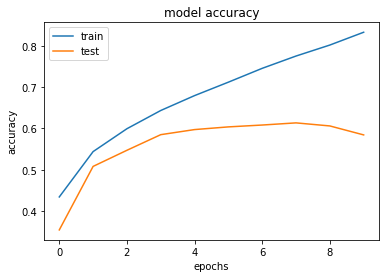

In [ ]:
build_plot(history)

Существенное расхождение кривых теста и тренировки. Сильно переобучается наша модель. Поработаем со второй нормализацией по счету:

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))
model.add(L.BatchNormalization())

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization_66 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 10)        23050     
_________________________________________________________________
batch_normalization_67 (Batc (None, 32, 32, 10)        40        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 100)             

Epoch 1/500
80/80 - 7s - loss: 1.6164 - acc: 0.4354 - val_loss: 1.9165 - val_acc: 0.3326
Epoch 2/500
80/80 - 5s - loss: 1.3031 - acc: 0.5369 - val_loss: 1.4778 - val_acc: 0.4788
Epoch 3/500
80/80 - 5s - loss: 1.1482 - acc: 0.5973 - val_loss: 1.3201 - val_acc: 0.5379
Epoch 4/500
80/80 - 5s - loss: 1.0266 - acc: 0.6397 - val_loss: 1.2595 - val_acc: 0.5583
Epoch 5/500
80/80 - 5s - loss: 0.9122 - acc: 0.6816 - val_loss: 1.1413 - val_acc: 0.5961
Epoch 6/500
80/80 - 5s - loss: 0.8190 - acc: 0.7180 - val_loss: 1.1324 - val_acc: 0.6081
Epoch 7/500
80/80 - 5s - loss: 0.7307 - acc: 0.7512 - val_loss: 1.1372 - val_acc: 0.6101
Epoch 8/500
80/80 - 5s - loss: 0.6511 - acc: 0.7775 - val_loss: 1.1652 - val_acc: 0.6092


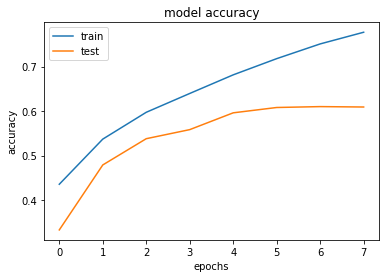

In [ ]:
history_1 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_1)

Стало несколько лучше. Меняем точно так же третью нормализацию:

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization_72 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 10)        23050     
_________________________________________________________________
batch_normalization_73 (Batc (None, 32, 32, 10)        40        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 100)             

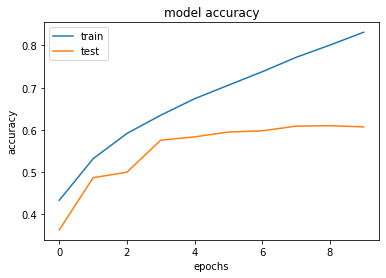

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))
model.add(L.BatchNormalization(momentum=0.9, epsilon=0.021))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_2 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_2)

На трейне результат стал лучше, но на тесте - практически не изменился. Убираем последнюю нормализацию совсем:

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization_78 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 10)        23050     
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 32, 10)        40        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 100)             

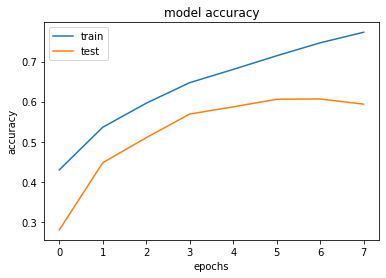

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_3 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_3)

Всё равно разрыв велик. В первой нормализации внесем другие показатели:

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization_83 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 10)        23050     
_________________________________________________________________
batch_normalization_84 (Batc (None, 32, 32, 10)        40        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 100)             

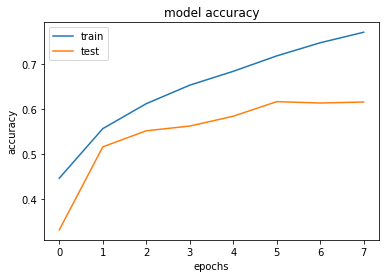

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_4 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_4)

Стало гораздо лучше. Добавим нормализацию в последний слой:

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization_94 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 10)        23050     
_________________________________________________________________
batch_normalization_95 (Batc (None, 32, 32, 10)        40        
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 100)             

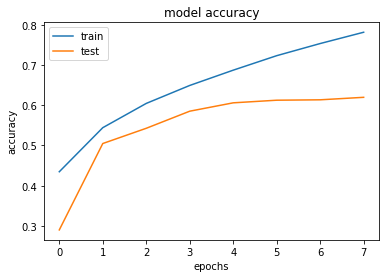

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_5 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_5)

Увеличим количество фильтров и размер ядра в первом сверточном слое и добавим второй такой слой:

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization_132 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 30)        768030    
_________________________________________________________________
batch_normalization_133 (Bat (None, 32, 32, 30)        120       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 32, 15)        28815     
_________________________________________________________________
batch_normalization_134 (Bat (None, 32, 32, 15)        60        
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 16, 16, 15)      

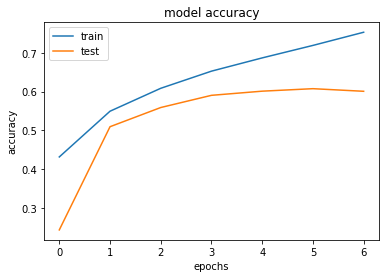

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Conv2D(filters=30, kernel_size=(10, 10), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.Conv2D(filters=15, kernel_size=(8, 8), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.01))

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_6 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_6)

Стало намного лучше, хоть и качество на трейне немного уменьшилось. Зато модель стала меньше переобучаться. Добавим еще один слой свертки:

In [ ]:
!rm -rf ./logs

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization_171 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 32, 32, 30)        768030    
_________________________________________________________________
batch_normalization_172 (Bat (None, 32, 32, 30)        120       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 15)        28815     
_________________________________________________________________
batch_normalization_173 (Bat (None, 32, 32, 15)        60        
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 32, 32, 15)      

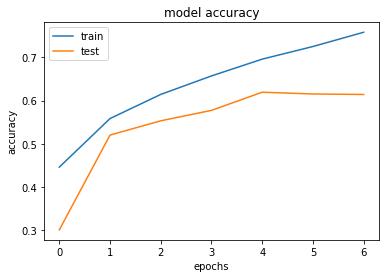

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Conv2D(filters=30, kernel_size=(10, 10), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))

model.add(L.Conv2D(filters=15, kernel_size=(8, 8), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.01))

model.add(L.Conv2D(filters=15, kernel_size=(8, 8), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_7 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_7)

Всё ближе и ближе. Добавим пулинги после каждого слоя свертки:

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 32, 32, 256)       1024      
_________________________________________________________________
batch_normalization_187 (Bat (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 32, 30)        768030    
_________________________________________________________________
batch_normalization_188 (Bat (None, 32, 32, 30)        120       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 30)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 16, 16, 15)        28815     
_________________________________________________________________
batch_normalization_189 (Bat (None, 16, 16, 15)      

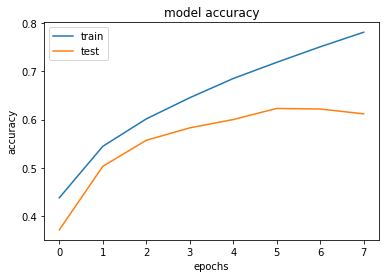

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Conv2D(filters=30, kernel_size=(10, 10), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(L.Conv2D(filters=15, kernel_size=(8, 8), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.01))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(L.Conv2D(filters=15, kernel_size=(8, 8), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(L.Flatten())

model.add(L.Dense(units=100, activation='relu'))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_8 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_8)

Увеличим количество нейронов в первом слое и в предпоследнем полносвязном слое:

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 32, 32, 512)       2048      
_________________________________________________________________
batch_normalization_211 (Bat (None, 32, 32, 512)       2048      
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 32, 32, 30)        1536030   
_________________________________________________________________
batch_normalization_212 (Bat (None, 32, 32, 30)        120       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 16, 16, 30)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 16, 15)        28815     
_________________________________________________________________
batch_normalization_213 (Bat (None, 16, 16, 15)      

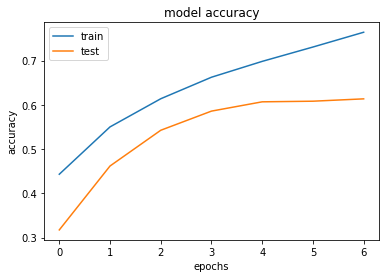

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size*2, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Conv2D(filters=30, kernel_size=(10, 10), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(L.Conv2D(filters=15, kernel_size=(8, 8), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.01))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(L.Conv2D(filters=15, kernel_size=(8, 8), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(L.Flatten())

model.add(L.Dense(hid_size/2, activation='relu'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_9 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_9)

Добавим еще один слой Dense:

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_199 (Dense)            (None, 32, 32, 512)       2048      
_________________________________________________________________
batch_normalization_220 (Bat (None, 32, 32, 512)       2048      
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 32, 32, 30)        1536030   
_________________________________________________________________
batch_normalization_221 (Bat (None, 32, 32, 30)        120       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 16, 16, 30)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 16, 16, 15)        28815     
_________________________________________________________________
batch_normalization_222 (Bat (None, 16, 16, 15)      

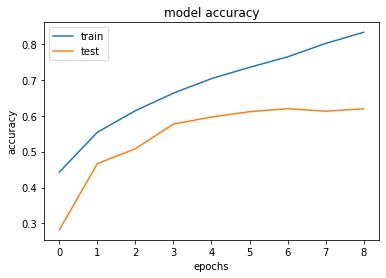

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size*2, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Conv2D(filters=30, kernel_size=(10, 10), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.8, epsilon=0.01))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(L.Conv2D(filters=15, kernel_size=(8, 8), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.01))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(L.Conv2D(filters=15, kernel_size=(8, 8), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))
model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(L.Flatten())

model.add(L.Dense(hid_size, activation='relu'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Dense(hid_size/2, activation='relu'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_9 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_9)

И всё же модель history_5 показала лучше результат. Вернемся к ней и просто добавим еще один слой Dense и в первом увеличим количество нейронов:

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_220 (Dense)            (None, 32, 32, 768)       3072      
_________________________________________________________________
batch_normalization_246 (Bat (None, 32, 32, 768)       3072      
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 32, 32, 30)        2304030   
_________________________________________________________________
batch_normalization_247 (Bat (None, 32, 32, 30)        120       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 32, 32, 10)        2710      
_________________________________________________________________
batch_normalization_248 (Bat (None, 32, 32, 10)        40        
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 16, 16, 10)      

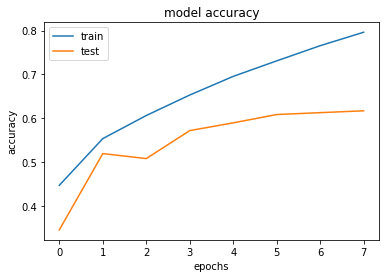

In [ ]:
model = keras.Sequential()

model.add(L.Dense(hid_size*3, activation='relu', input_shape=(X_train.shape[1:])))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Conv2D(filters=30, kernel_size=(10, 10), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))


model.add(L.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='sigmoid'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(L.Flatten())

model.add(L.Dense(hid_size, activation='relu'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Dense(hid_size/2, activation='relu'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.add(L.Activation('relu'))
model.add(L.Dense(units=10, activation='softmax'))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
history_10 = create_model().fit(X_train, y_train, batch_size=500, epochs=500, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))
build_plot(history_10)

На этом этапе схождение получилось несколько ближе, чем раньше. Остановимся пока на нем. Будем совершенствовать нашу сеть в следующем задании:

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [14]:
from tensorflow.keras.applications.resnet import ResNet50

In [15]:
!rm -rf ./logs

In [96]:
backbone = ResNet50(input_shape=(X_train.shape[1:]), 
                 classes=10, 
                 include_top=False, 
                 weights='imagenet')

model = keras.Sequential()
model.add(backbone)
model.add(L.GlobalAveragePooling2D())
model.add(L.Flatten())

model.add(L.Dense(256, activation=L.LeakyReLU(alpha=0.3)))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))
model.add(L.Dropout(0.2))

model.add(L.Dense(128, activation=L.LeakyReLU(alpha=0.2)))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))
model.add(L.Dropout(0.3))

model.add(L.Dense(64, activation=L.LeakyReLU(alpha=0.2)))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))
model.add(L.Dropout(0.3))

model.add(L.Dense(32, activation=L.LeakyReLU(alpha=0.1)))
model.add(L.BatchNormalization(momentum=0.999, epsilon=0.00001))
model.add(L.Dropout(0.5))

model.add(L.Dense(10, activation='softmax'))

opt_rms = keras.optimizers.RMSprop(lr=0.0002, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_rms, metrics=['acc'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_17  (None, 2048)              0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_84 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_71 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 128)             

In [97]:
%%time
model.fit(X_train, y_train, batch_size=100, epochs=1000, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))   # без аугментации

Epoch 1/1000
400/400 - 43s - loss: 1.9794 - acc: 0.3753 - val_loss: 2.3464 - val_acc: 0.1007
Epoch 2/1000
400/400 - 29s - loss: 1.0948 - acc: 0.6806 - val_loss: 2.3296 - val_acc: 0.4960
Epoch 3/1000
400/400 - 28s - loss: 0.8201 - acc: 0.7762 - val_loss: 1.0283 - val_acc: 0.7642
Epoch 4/1000
400/400 - 29s - loss: 0.6401 - acc: 0.8311 - val_loss: 0.9224 - val_acc: 0.7892
Epoch 5/1000
400/400 - 29s - loss: 0.5076 - acc: 0.8706 - val_loss: 0.9783 - val_acc: 0.7790
Epoch 6/1000
400/400 - 29s - loss: 0.4144 - acc: 0.8968 - val_loss: 0.8709 - val_acc: 0.8026
Epoch 7/1000
400/400 - 29s - loss: 0.3358 - acc: 0.9216 - val_loss: 0.8837 - val_acc: 0.8138
Epoch 8/1000
400/400 - 29s - loss: 0.2764 - acc: 0.9354 - val_loss: 0.9228 - val_acc: 0.8125
CPU times: user 3min 39s, sys: 31.6 s, total: 4min 10s
Wall time: 4min 10s


In [105]:
# %%time
# model.fit_generator(X_datagen.flow(X_train, y_train, batch_size=32), epochs=1000, verbose=2, callbacks=callbacks, validation_data=(X_val, y_val))   # с аугментацией

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
1250/1250 - 80s - loss: 8.8500 - acc: 0.0965 - val_loss: 2.5122 - val_acc: 0.0000e+00
Epoch 2/1000
1250/1250 - 75s - loss: 4.9632 - acc: 0.1309 - val_loss: 4.0246 - val_acc: 1.0000
Epoch 3/1000
1250/1250 - 75s - loss: 3.1073 - acc: 0.1938 - val_loss: 2.4691 - val_acc: 0.9745
Epoch 4/1000
1250/1250 - 75s - loss: 2.3852 - acc: 0.2128 - val_loss: 3.7307 - val_acc: 0.0068
Epoch 5/1000
1250/1250 - 75s - loss: 2.4324 - acc: 0.1558 - val_loss: 3.4490 - val_acc: 0.0895
CPU times: user 5min 18s, sys: 1min 47s, total: 7min 6s
Wall time: 6min 21s


Момент истины: проверьте, какого качества достигла ваша сеть.

In [98]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



 Test_acc = 0.8002
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

Итак:  
Этап 1. Запустила всё как есть. Test_acc = 0.6267  
Этап 2. Изменила число фильтров и их размер (взяла 30 размером 10Х10). Test_acc = 0.6155  
Этап 3. Воспользовалась архитектурой ResNet50. Пока поставила include_top=False и вручную завела последние 2 слоя. Что можно сказать: обучение идет дольше, чем до этого. Test_acc = 0.4921   
Этап 4. Добавила парочку полносвязных слоев и Flatten (до этого в ResNet вытягивание в вектор не использовала). Test_acc сразу вырос до 0.6872.  
Этап 5. Изменила оптимизатор на Adamax (он показал результат лучше в одном из заданий). Итог - Test_acc = 0.7775. Почти достигла цели.  
Этап 6. Добавила Dropout. Test_acc = 0.7832  
Этап 7. Увеличила размер батча. Test_acc = 0.7712    
Этап 8. Вернула размер батча (100), добавила слой GlobalAveragePooling2D. Test_acc = 0.7755.  
Этап 9.  Увеличила количество нейронов в 2 раза в подносвязном первом слое. Test_acc = 0.7518.  
Этап 10. Добавила еще один полносвязный слой. Test_acc = 0.7487  
Этап 11. Добавила очередной полносвязный слой. Test_acc = 0.7389  
Этап 12. Удалила полносвязный слой, поменяла во втором полносвязном слое активацию с "relu" на "leaky relu". Test_acc = 0.7735
Этап 13. Добавила больше нейронов в первые 2 слоя. Test_acc = 0.7734  
Этап 14. Добавила еще один полносвязный слой. Test_acc = 0.7854  
Этап 15. Сдвинула leaky relu на один слой вперед. Test_acc = 0.798  
... (дальше потеря памяти и трех дней)))  
Этап 100500. Поменяла оптимизатор с Adamax на RMSprop. Test_acc = 0.7897  
Этап 100501. Подобрала learning_rate для RMSprop. ***Test_acc = 0.8002
Это победа!***  
Ура-Ура!  
А с аугментацией не очень получилось. Может, вы подскажете, что можно сделать, чтобы аугментация "выстрелила". Спасибо!  
А в целом - очень крутое ДЗ. Прокачивает очень хорошо. Надеюсь, второе будет не хуже.


